# Challenge 3: Artifical Neural Networks

<a target="_blank" href="https://colab.research.google.com/github/GaiaSaveri/intro-to-ml/blob/main/challenges/challenge-three.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


Using Fully Connected Neural Networks and Convolutional Neural Networks, perform the following tasks on [this data set](https://pytorch.org/vision/stable/generated/torchvision.datasets.KMNIST.html#torchvision.datasets.KMNIST).
1. Data exploration.
2. For each architecture, tune the number of the hidden layers ($\le 3$), the optimizer, and some hyperparameters of your choice. How many tries to do is up to your discretion.
3. Summarise your results in a table and comment on them in the report.
4. For a model (not necessarily the best performing one), plot training loss vs testing loss and training accuracy vs testing accuracy, and comment on what you see.

In [ ]:
# import all needed packages
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from time import time
import random
import torch.nn.functional as F

torch.manual_seed(1)
np.random.seed(2)
random.seed(3)

In [ ]:
batch_size = 32

# DataLoader Train
trainset = torchvision.datasets.KMNIST(root='./data', train=True, download=True,
    transform=torchvision.transforms.ToTensor())

trainloader = data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# DataLoader Test
testset = torchvision.datasets.KMNIST(root='./data', train=False, download=True,
    transform=torchvision.transforms.ToTensor())

testloader = data.DataLoader(testset, batch_size=batch_size, shuffle=False)

100%|██████████| 18165135/18165135 [00:20<00:00, 877008.65it/s] 


Extracting ./data/KMNIST/raw/train-images-idx3-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 29497/29497 [00:00<00:00, 132971.12it/s]


Extracting ./data/KMNIST/raw/train-labels-idx1-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 3041136/3041136 [00:03<00:00, 803294.89it/s]


Extracting ./data/KMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 5120/5120 [00:00<00:00, 5387565.60it/s]

Extracting ./data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/KMNIST/raw



## Data exploration

In [ ]:
testset

Dataset KMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

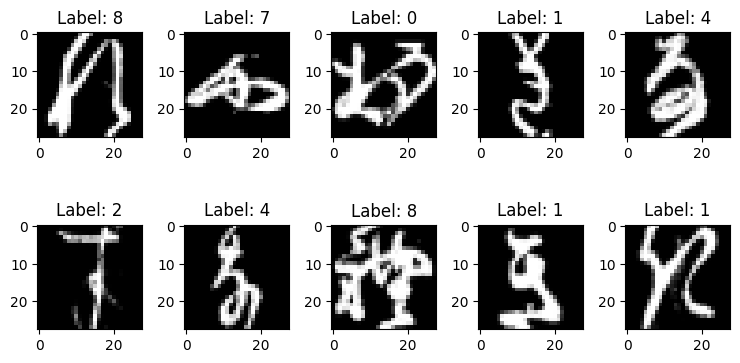

In [ ]:
num_row = 2
num_col = 5

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col, 2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(trainset.data[i], cmap='gray')
    ax.set_title('Label: {}'.format(trainset.targets[i]))
plt.tight_layout()
plt.show()

In [ ]:
# printing data shapes
print("Single image dimensions:", trainset.data[0].shape)
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Single image dimensions: torch.Size([28, 28])
Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


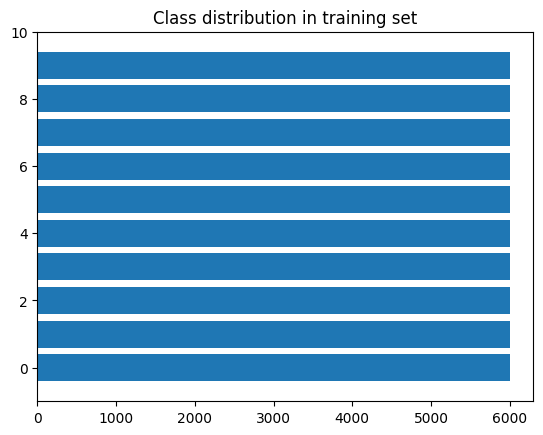

In [ ]:
# distribuzione delle classi nel training set
classes_name, counts = np.unique(trainset.targets, return_counts=True)
plt.barh(classes_name, counts)
plt.ylim(-1,10)
plt.title('Class distribution in training set')
plt.show()

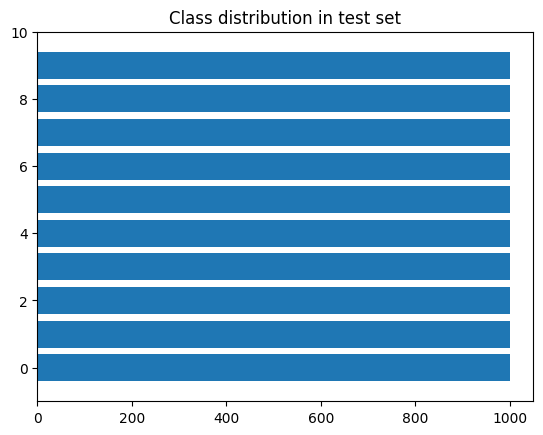

In [ ]:
# distribuzione delle classi nel test set
classes_name, counts = np.unique(testset.targets, return_counts=True)
plt.barh(classes_name, counts)
plt.ylim(-1,10)
plt.title('Class distribution in test set')
plt.show()

## Fully Connected Neural Networks

In [ ]:
class FCNN_1(nn.Module):
    def __init__(self):
        super(FCNN_1, self).__init__()
        self.l1 = nn.Linear(28*28, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, 10) # output layer

    def forward(self, x):
        x = x.view(-1, 28*28) # flatten the input image
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.softmax(self.l3(x), dim=1) # softmax for classification in 10 classes

        return x

In [ ]:
class FCNN_2(nn.Module):
    def __init__(self):
        super(FCNN_2, self).__init__()
        self.l1 = nn.Linear(28*28, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, 32)
        self.l4 = nn.Linear(32, 10) # output layer

    def forward(self, x):
        x = x.view(-1, 28*28) # flatten the input image
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.softmax(self.l4(x), dim=1) # softmax for classification in 10 classes
        return x

In [ ]:
def get_accuracy(logit, target):
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()

def train_model(model, num_epochs, trainloader, testloader, criterion, optimizer):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    for epoch in range(num_epochs):
        train_running_loss = 0.0
        train_acc = 0.0
        test_running_loss = 0.0
        test_acc = 0.0

        # Set the model to training mode
        model = model.train()
        start = time()

        ## training step
        for i, (images, labels) in enumerate(trainloader):

            images = images.to(device)
            labels = labels.to(device)

            ## forward + backprop + loss
            logits = model(images) # predizione
            loss = criterion(logits, labels) # calcolo la loss

            # Reset the gradients to zero
            optimizer.zero_grad()

            loss.backward()

            ## update model params
            optimizer.step()

            train_running_loss += loss.item()
            train_acc += get_accuracy(logits, labels)

        train_losses.append(train_running_loss / i)
        train_accs.append(train_acc/i)

        ## testing step
        with torch.no_grad():
            model = model.eval()
            for j, (images, labels) in enumerate(testloader):

                images = images.to(device)
                labels = labels.to(device)

                logits = model(images)
                loss = criterion(logits, labels)

                test_running_loss += loss.item()
                test_acc += get_accuracy(logits, labels)

        test_losses.append(test_running_loss / j)
        test_accs.append(test_acc/j)

        model.eval()
        print(f"Epoch: {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Train Accuracy: {train_accs[-1]:.4f} | Test Loss: {test_losses[-1]:.4f} | Test Accuracy: {test_accs[-1]:.4f} | Time: {time()-start:.2f}")

    return train_losses, train_accs, test_losses, test_accs

In [ ]:
epochs = 10
model_fcnn = FCNN_1()
criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(model_fcnn.parameters(), lr=0.001)

_, _, _, _, = train_model(model_fcnn, epochs, trainloader, testloader, criterion, optimizer)

Epoch: 1 | Train Loss: 1.6829 | Train Accuracy: 78.8137 | Test Loss: 1.7837 | Test Accuracy: 68.6298 | Time: 17.06
Epoch: 2 | Train Loss: 1.6097 | Train Accuracy: 85.4889 | Test Loss: 1.7451 | Test Accuracy: 72.4760 | Time: 16.45
Epoch: 3 | Train Loss: 1.5765 | Train Accuracy: 88.8007 | Test Loss: 1.7046 | Test Accuracy: 76.4123 | Time: 16.17
Epoch: 4 | Train Loss: 1.5621 | Train Accuracy: 90.1397 | Test Loss: 1.6910 | Test Accuracy: 77.9748 | Time: 16.85
Epoch: 5 | Train Loss: 1.5536 | Train Accuracy: 90.9618 | Test Loss: 1.6811 | Test Accuracy: 78.9263 | Time: 16.60
Epoch: 6 | Train Loss: 1.5479 | Train Accuracy: 91.5205 | Test Loss: 1.6689 | Test Accuracy: 79.8878 | Time: 16.31
Epoch: 7 | Train Loss: 1.5422 | Train Accuracy: 92.1041 | Test Loss: 1.6630 | Test Accuracy: 80.6090 | Time: 16.63
Epoch: 8 | Train Loss: 1.5347 | Train Accuracy: 92.8145 | Test Loss: 1.6544 | Test Accuracy: 81.5304 | Time: 17.31
Epoch: 9 | Train Loss: 1.5294 | Train Accuracy: 93.3498 | Test Loss: 1.6576 | Te

In [ ]:
epochs = 10
model_fcnn = FCNN_2()
criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(model_fcnn.parameters(), lr=0.001)

_, _, _, _, = train_model(model_fcnn, epochs, trainloader, testloader, criterion, optimizer)

Epoch: 1 | Train Loss: 1.6979 | Train Accuracy: 77.1211 | Test Loss: 1.7863 | Test Accuracy: 68.4495 | Time: 17.82
Epoch: 2 | Train Loss: 1.6045 | Train Accuracy: 85.9942 | Test Loss: 1.7468 | Test Accuracy: 72.0653 | Time: 13.25
Epoch: 3 | Train Loss: 1.5840 | Train Accuracy: 87.9686 | Test Loss: 1.7134 | Test Accuracy: 75.6711 | Time: 13.33
Epoch: 4 | Train Loss: 1.5689 | Train Accuracy: 89.4260 | Test Loss: 1.7055 | Test Accuracy: 76.3522 | Time: 13.32
Epoch: 5 | Train Loss: 1.5613 | Train Accuracy: 90.1497 | Test Loss: 1.7131 | Test Accuracy: 75.4207 | Time: 13.58
Epoch: 6 | Train Loss: 1.5559 | Train Accuracy: 90.6767 | Test Loss: 1.6790 | Test Accuracy: 78.9163 | Time: 14.54
Epoch: 7 | Train Loss: 1.5515 | Train Accuracy: 91.0919 | Test Loss: 1.6785 | Test Accuracy: 79.0164 | Time: 13.26
Epoch: 8 | Train Loss: 1.5426 | Train Accuracy: 92.0041 | Test Loss: 1.6270 | Test Accuracy: 84.3049 | Time: 13.24
Epoch: 9 | Train Loss: 1.5193 | Train Accuracy: 94.3403 | Test Loss: 1.6083 | Te

In [ ]:
# tuning of hyper-parameters using Adam
learning_rates = [0.1, 0.01, 0.001, 0.0001]

for lr in learning_rates:
    model = FCNN_2()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    print("Learning rate:", lr)

    for epoch in range(10):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = model.to(device)

        train_running_loss = 0.0
        train_acc = 0.0
        test_running_loss = 0.0
        test_acc = 0.0

        # Set the model to training mode
        model = model.train()
        start = time()

        ## training step
        for i, (images, labels) in enumerate(trainloader):

            images = images.to(device)
            labels = labels.to(device)

            ## forward + backprop + loss
            logits = model(images)
            loss = criterion(logits, labels)

            # Reset the gradients to zero
            optimizer.zero_grad()

            loss.backward()

            ## update model params
            optimizer.step()

            train_running_loss += loss.item()
            train_acc += get_accuracy(logits, labels)

        train_losses.append(train_running_loss / i)
        train_accs.append(train_acc/i)

        ## testing step
        with torch.no_grad():
            model = model.eval()
            for j, (images, labels) in enumerate(testloader):

                images = images.to(device)
                labels = labels.to(device)

                logits = model(images)
                loss = criterion(logits, labels)

                test_running_loss += loss.item()
                test_acc += get_accuracy(logits, labels)

        test_losses.append(test_running_loss / j)
        test_accs.append(test_acc/j)

        model.eval()
        print(f"Epoch: {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Train Accuracy: {train_accs[-1]:.4f} | Test Loss: {test_losses[-1]:.4f} | Test Accuracy: {test_accs[-1]:.4f} | Time: {time()-start:.2f}")

Learning rate: 0.1
Epoch: 1 | Train Loss: 2.3625 | Train Accuracy: 9.9937 | Test Loss: 2.3688 | Test Accuracy: 10.0260 | Time: 25.32
Epoch: 2 | Train Loss: 2.3624 | Train Accuracy: 10.0053 | Test Loss: 2.3688 | Test Accuracy: 10.0260 | Time: 20.22
Epoch: 3 | Train Loss: 2.3624 | Train Accuracy: 10.0053 | Test Loss: 2.3688 | Test Accuracy: 10.0260 | Time: 20.54
Epoch: 4 | Train Loss: 2.3624 | Train Accuracy: 10.0053 | Test Loss: 2.3688 | Test Accuracy: 10.0260 | Time: 21.08
Epoch: 5 | Train Loss: 2.3624 | Train Accuracy: 10.0053 | Test Loss: 2.3688 | Test Accuracy: 10.0260 | Time: 20.22
Epoch: 6 | Train Loss: 2.3624 | Train Accuracy: 10.0053 | Test Loss: 2.3688 | Test Accuracy: 10.0260 | Time: 21.85
Epoch: 7 | Train Loss: 2.3624 | Train Accuracy: 10.0053 | Test Loss: 2.3688 | Test Accuracy: 10.0260 | Time: 20.82
Epoch: 8 | Train Loss: 2.3624 | Train Accuracy: 10.0053 | Test Loss: 2.3688 | Test Accuracy: 10.0260 | Time: 20.88
Epoch: 9 | Train Loss: 2.3624 | Train Accuracy: 10.0053 | Test

In [ ]:
# tuning of hyper-parameters using SGD
learning_rates = [0.1, 0.01, 0.001, 0.0001]

for lr in learning_rates:
    model = FCNN_2()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    print("Learning rate:", lr)

    for epoch in range(10):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = model.to(device)

        train_running_loss = 0.0
        train_acc = 0.0
        test_running_loss = 0.0
        test_acc = 0.0

        # Set the model to training mode
        model = model.train()
        start = time()

        ## training step
        for i, (images, labels) in enumerate(trainloader):

            images = images.to(device)
            labels = labels.to(device)

            ## forward + backprop + loss
            logits = model(images)
            loss = criterion(logits, labels)

            # Reset the gradients to zero
            optimizer.zero_grad()

            loss.backward()

            ## update model params
            optimizer.step()

            train_running_loss += loss.item()
            train_acc += get_accuracy(logits, labels)

        train_losses.append(train_running_loss / i)
        train_accs.append(train_acc/i)

        ## testing step
        with torch.no_grad():
            model = model.eval()
            for j, (images, labels) in enumerate(testloader):

                images = images.to(device)
                labels = labels.to(device)

                logits = model(images)
                loss = criterion(logits, labels)

                test_running_loss += loss.item()
                test_acc += get_accuracy(logits, labels)

        test_losses.append(test_running_loss / j)
        test_accs.append(test_acc/j)

        model.eval()
        print(f"Epoch: {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Train Accuracy: {train_accs[-1]:.4f} | Test Loss: {test_losses[-1]:.4f} | Test Accuracy: {test_accs[-1]:.4f} | Time: {time()-start:.2f}")

Learning rate: 0.1
Epoch: 1 | Train Loss: 2.1317 | Train Accuracy: 34.4467 | Test Loss: 1.9665 | Test Accuracy: 50.4207 | Time: 14.39
Epoch: 2 | Train Loss: 1.7779 | Train Accuracy: 68.6833 | Test Loss: 1.9192 | Test Accuracy: 54.8878 | Time: 14.72
Epoch: 3 | Train Loss: 1.7348 | Train Accuracy: 72.8772 | Test Loss: 1.8740 | Test Accuracy: 59.3149 | Time: 14.42
Epoch: 4 | Train Loss: 1.6976 | Train Accuracy: 76.6259 | Test Loss: 1.8332 | Test Accuracy: 63.4716 | Time: 14.92
Epoch: 5 | Train Loss: 1.6747 | Train Accuracy: 78.7937 | Test Loss: 1.8029 | Test Accuracy: 66.3862 | Time: 15.56
Epoch: 6 | Train Loss: 1.5991 | Train Accuracy: 86.8563 | Test Loss: 1.7310 | Test Accuracy: 74.3790 | Time: 14.60
Epoch: 7 | Train Loss: 1.5719 | Train Accuracy: 89.2943 | Test Loss: 1.7028 | Test Accuracy: 76.6927 | Time: 14.64
Epoch: 8 | Train Loss: 1.5620 | Train Accuracy: 90.2715 | Test Loss: 1.6948 | Test Accuracy: 77.5541 | Time: 14.84
Epoch: 9 | Train Loss: 1.5555 | Train Accuracy: 90.8668 | Tes

In [ ]:
epochs = 20
model_fcnn = FCNN_2()
criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(model_fcnn.parameters(), lr=0.001)

train_losses_fcnn, train_accs_fcnn, test_losses_fcnn, test_accs_fcnn = train_model(model_fcnn, epochs, trainloader, testloader, criterion, optimizer)

Epoch: 1 | Train Loss: 1.7020 | Train Accuracy: 76.7976 | Test Loss: 1.7969 | Test Accuracy: 67.3077 | Time: 13.41
Epoch: 2 | Train Loss: 1.6236 | Train Accuracy: 83.9981 | Test Loss: 1.7642 | Test Accuracy: 70.3926 | Time: 13.40
Epoch: 3 | Train Loss: 1.5873 | Train Accuracy: 87.5951 | Test Loss: 1.7325 | Test Accuracy: 73.8482 | Time: 13.22
Epoch: 4 | Train Loss: 1.5673 | Train Accuracy: 89.6328 | Test Loss: 1.7141 | Test Accuracy: 75.4006 | Time: 13.27
Epoch: 5 | Train Loss: 1.5531 | Train Accuracy: 91.0102 | Test Loss: 1.6794 | Test Accuracy: 79.0365 | Time: 13.31
Epoch: 6 | Train Loss: 1.5451 | Train Accuracy: 91.7940 | Test Loss: 1.6726 | Test Accuracy: 79.6775 | Time: 13.23
Epoch: 7 | Train Loss: 1.5422 | Train Accuracy: 92.0374 | Test Loss: 1.6734 | Test Accuracy: 79.5272 | Time: 13.40
Epoch: 8 | Train Loss: 1.5369 | Train Accuracy: 92.5794 | Test Loss: 1.6583 | Test Accuracy: 81.0998 | Time: 13.43
Epoch: 9 | Train Loss: 1.5324 | Train Accuracy: 93.0213 | Test Loss: 1.6578 | Te

## Convolutional Neural Networks

In [ ]:
class CNN_1(nn.Module):
    def __init__(self):
        super(CNN_1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.l1 = nn.Linear(32*4*4, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, kernel_size=2)
        x = torch.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 32*4*4)
        x = self.l1(x)

        return nn.functional.softmax(x, dim=1)

In [ ]:
class CNN_2(nn.Module):
    def __init__(self):
        super(CNN_2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.l1 = nn.Linear(32*4*4, 128)
        self.l2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, kernel_size=2)
        x = torch.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 32*4*4)
        x = F.relu(self.l1(x))
        x = self.l2(x)

        return nn.functional.softmax(x, dim=1)

In [ ]:
epochs = 10
model_cnn = CNN_1()
criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)

_, _, _, _, = train_model(model_cnn, epochs, trainloader, testloader, criterion, optimizer)

Epoch: 1 | Train Loss: 1.6673 | Train Accuracy: 80.0594 | Test Loss: 1.7529 | Test Accuracy: 71.5845 | Time: 39.78
Epoch: 2 | Train Loss: 1.5680 | Train Accuracy: 89.6645 | Test Loss: 1.6908 | Test Accuracy: 77.8145 | Time: 39.08
Epoch: 3 | Train Loss: 1.5503 | Train Accuracy: 91.3471 | Test Loss: 1.6578 | Test Accuracy: 80.9896 | Time: 38.27
Epoch: 4 | Train Loss: 1.5425 | Train Accuracy: 92.0841 | Test Loss: 1.6533 | Test Accuracy: 81.6607 | Time: 38.04
Epoch: 5 | Train Loss: 1.5370 | Train Accuracy: 92.5860 | Test Loss: 1.6387 | Test Accuracy: 83.0028 | Time: 37.29
Epoch: 6 | Train Loss: 1.5267 | Train Accuracy: 93.6499 | Test Loss: 1.6234 | Test Accuracy: 84.5853 | Time: 39.61
Epoch: 7 | Train Loss: 1.5224 | Train Accuracy: 94.0201 | Test Loss: 1.6255 | Test Accuracy: 84.2849 | Time: 39.57
Epoch: 8 | Train Loss: 1.5195 | Train Accuracy: 94.3453 | Test Loss: 1.6103 | Test Accuracy: 85.7572 | Time: 39.55
Epoch: 9 | Train Loss: 1.5170 | Train Accuracy: 94.5821 | Test Loss: 1.6187 | Te

In [ ]:
epochs = 10
model_cnn = CNN_2()
criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)

_, _, _, _, = train_model(model_cnn, epochs, trainloader, testloader, criterion, optimizer)

Epoch: 1 | Train Loss: 1.6718 | Train Accuracy: 79.3690 | Test Loss: 1.7384 | Test Accuracy: 73.1270 | Time: 43.10
Epoch: 2 | Train Loss: 1.5732 | Train Accuracy: 89.0358 | Test Loss: 1.6712 | Test Accuracy: 79.9679 | Time: 42.50
Epoch: 3 | Train Loss: 1.5531 | Train Accuracy: 91.0302 | Test Loss: 1.6574 | Test Accuracy: 80.9896 | Time: 42.42
Epoch: 4 | Train Loss: 1.5315 | Train Accuracy: 93.1530 | Test Loss: 1.6328 | Test Accuracy: 83.5737 | Time: 42.97
Epoch: 5 | Train Loss: 1.5259 | Train Accuracy: 93.6733 | Test Loss: 1.6225 | Test Accuracy: 84.5853 | Time: 41.97
Epoch: 6 | Train Loss: 1.5045 | Train Accuracy: 95.8344 | Test Loss: 1.5500 | Test Accuracy: 91.9271 | Time: 41.79
Epoch: 7 | Train Loss: 1.4854 | Train Accuracy: 97.7555 | Test Loss: 1.5402 | Test Accuracy: 92.9387 | Time: 41.50
Epoch: 8 | Train Loss: 1.4823 | Train Accuracy: 98.0523 | Test Loss: 1.5300 | Test Accuracy: 93.9303 | Time: 42.65
Epoch: 9 | Train Loss: 1.4796 | Train Accuracy: 98.3124 | Test Loss: 1.5310 | Te

In [ ]:
# tuning of hyper-parameters using Adam
learning_rates = [0.1, 0.01, 0.001, 0.0001]

for lr in learning_rates:
    model = CNN_2()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    print("Learning rate:", lr)

    for epoch in range(10):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = model.to(device)

        train_running_loss = 0.0
        train_acc = 0.0
        test_running_loss = 0.0
        test_acc = 0.0

        # Set the model to training mode
        model = model.train()
        start = time()

        ## training step
        for i, (images, labels) in enumerate(trainloader):

            images = images.to(device)
            labels = labels.to(device)

            ## forward + backprop + loss
            logits = model(images)
            loss = criterion(logits, labels)

            # Reset the gradients to zero
            optimizer.zero_grad()

            loss.backward()

            ## update model params
            optimizer.step()

            train_running_loss += loss.item()
            train_acc += get_accuracy(logits, labels)

        train_losses.append(train_running_loss / i)
        train_accs.append(train_acc/i)

        ## testing step
        with torch.no_grad():
            model = model.eval()
            for j, (images, labels) in enumerate(testloader):

                images = images.to(device)
                labels = labels.to(device)

                logits = model(images)
                loss = criterion(logits, labels)

                test_running_loss += loss.item()
                test_acc += get_accuracy(logits, labels)

        test_losses.append(test_running_loss / j)
        test_accs.append(test_acc/j)

        model.eval()
        print(f"Epoch: {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Train Accuracy: {train_accs[-1]:.4f} | Test Loss: {test_losses[-1]:.4f} | Test Accuracy: {test_accs[-1]:.4f} | Time: {time()-start:.2f}")

Learning rate: 0.1
Epoch: 1 | Train Loss: 2.3625 | Train Accuracy: 9.9970 | Test Loss: 2.3687 | Test Accuracy: 10.0361 | Time: 41.85
Epoch: 2 | Train Loss: 2.3624 | Train Accuracy: 10.0053 | Test Loss: 2.3687 | Test Accuracy: 10.0361 | Time: 42.70
Epoch: 3 | Train Loss: 2.3624 | Train Accuracy: 10.0053 | Test Loss: 2.3687 | Test Accuracy: 10.0361 | Time: 42.46
Epoch: 4 | Train Loss: 2.3624 | Train Accuracy: 10.0053 | Test Loss: 2.3687 | Test Accuracy: 10.0361 | Time: 43.36
Epoch: 5 | Train Loss: 2.3624 | Train Accuracy: 10.0053 | Test Loss: 2.3687 | Test Accuracy: 10.0361 | Time: 43.62
Epoch: 6 | Train Loss: 2.3624 | Train Accuracy: 10.0053 | Test Loss: 2.3687 | Test Accuracy: 10.0361 | Time: 42.81
Epoch: 7 | Train Loss: 2.3624 | Train Accuracy: 10.0053 | Test Loss: 2.3687 | Test Accuracy: 10.0361 | Time: 43.83
Epoch: 8 | Train Loss: 2.3624 | Train Accuracy: 10.0053 | Test Loss: 2.3687 | Test Accuracy: 10.0361 | Time: 49.45
Epoch: 9 | Train Loss: 2.3624 | Train Accuracy: 10.0053 | Test

In [ ]:
# tuning of hyper-parameters using SGD
learning_rates = [0.1, 0.01, 0.001, 0.0001]

for lr in learning_rates:
    model = CNN_2()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    print("Learning rate:", lr)

    for epoch in range(10):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = model.to(device)

        train_running_loss = 0.0
        train_acc = 0.0
        test_running_loss = 0.0
        test_acc = 0.0

        # Set the model to training mode
        model = model.train()
        start = time()

        ## training step
        for i, (images, labels) in enumerate(trainloader):

            images = images.to(device)
            labels = labels.to(device)

            ## forward + backprop + loss
            logits = model(images)
            loss = criterion(logits, labels)

            # Reset the gradients to zero
            optimizer.zero_grad()

            loss.backward()

            ## update model params
            optimizer.step()

            train_running_loss += loss.item()
            train_acc += get_accuracy(logits, labels)

        train_losses.append(train_running_loss / i)
        train_accs.append(train_acc/i)

        ## testing step
        with torch.no_grad():
            model = model.eval()
            for j, (images, labels) in enumerate(testloader):

                images = images.to(device)
                labels = labels.to(device)

                logits = model(images)
                loss = criterion(logits, labels)

                test_running_loss += loss.item()
                test_acc += get_accuracy(logits, labels)

        test_losses.append(test_running_loss / j)
        test_accs.append(test_acc/j)

        model.eval()
        print(f"Epoch: {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Train Accuracy: {train_accs[-1]:.4f} | Test Loss: {test_losses[-1]:.4f} | Test Accuracy: {test_accs[-1]:.4f} | Time: {time()-start:.2f}")

Learning rate: 0.1
Epoch: 1 | Train Loss: 1.8291 | Train Accuracy: 64.0892 | Test Loss: 1.7993 | Test Accuracy: 67.2175 | Time: 39.61
Epoch: 2 | Train Loss: 1.6128 | Train Accuracy: 85.1871 | Test Loss: 1.7235 | Test Accuracy: 74.5192 | Time: 40.81
Epoch: 3 | Train Loss: 1.5790 | Train Accuracy: 88.4689 | Test Loss: 1.6976 | Test Accuracy: 77.1935 | Time: 39.88
Epoch: 4 | Train Loss: 1.5647 | Train Accuracy: 89.8946 | Test Loss: 1.6788 | Test Accuracy: 79.1066 | Time: 40.00
Epoch: 5 | Train Loss: 1.5565 | Train Accuracy: 90.6567 | Test Loss: 1.6529 | Test Accuracy: 81.6907 | Time: 39.61
Epoch: 6 | Train Loss: 1.5414 | Train Accuracy: 92.1608 | Test Loss: 1.6325 | Test Accuracy: 83.8041 | Time: 39.64
Epoch: 7 | Train Loss: 1.5184 | Train Accuracy: 94.5004 | Test Loss: 1.5749 | Test Accuracy: 89.4832 | Time: 40.25
Epoch: 8 | Train Loss: 1.5024 | Train Accuracy: 96.1046 | Test Loss: 1.5686 | Test Accuracy: 89.9539 | Time: 39.72
Epoch: 9 | Train Loss: 1.4989 | Train Accuracy: 96.4398 | Tes

In [ ]:
epochs = 20
model_cnn = CNN_2()
criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)

train_losses_cnn, train_accs_cnn, test_losses_cnn, test_accs_cnn = train_model(model_cnn, epochs, trainloader, testloader, criterion, optimizer)

Epoch: 1 | Train Loss: 1.6940 | Train Accuracy: 77.0828 | Test Loss: 1.6989 | Test Accuracy: 77.3738 | Time: 17.98
Epoch: 2 | Train Loss: 1.5479 | Train Accuracy: 91.6455 | Test Loss: 1.6427 | Test Accuracy: 82.5621 | Time: 14.12
Epoch: 3 | Train Loss: 1.5286 | Train Accuracy: 93.4682 | Test Loss: 1.6406 | Test Accuracy: 82.9327 | Time: 14.74
Epoch: 4 | Train Loss: 1.5209 | Train Accuracy: 94.2102 | Test Loss: 1.6173 | Test Accuracy: 85.2564 | Time: 14.52
Epoch: 5 | Train Loss: 1.5156 | Train Accuracy: 94.7239 | Test Loss: 1.6021 | Test Accuracy: 86.6386 | Time: 14.48
Epoch: 6 | Train Loss: 1.4881 | Train Accuracy: 97.4920 | Test Loss: 1.5571 | Test Accuracy: 91.1358 | Time: 14.29
Epoch: 7 | Train Loss: 1.4836 | Train Accuracy: 97.9189 | Test Loss: 1.5382 | Test Accuracy: 93.1691 | Time: 14.28
Epoch: 8 | Train Loss: 1.4808 | Train Accuracy: 98.1790 | Test Loss: 1.5395 | Test Accuracy: 92.9587 | Time: 14.29
Epoch: 9 | Train Loss: 1.4796 | Train Accuracy: 98.3124 | Test Loss: 1.5348 | Te

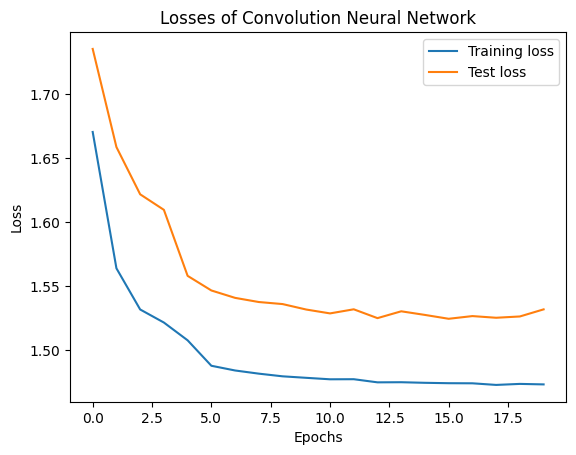

In [ ]:
plt.plot(train_losses_cnn, label='Training loss')
plt.plot(test_losses_cnn, label='Test loss')
plt.legend()
plt.title('Losses of Convolution Neural Network')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

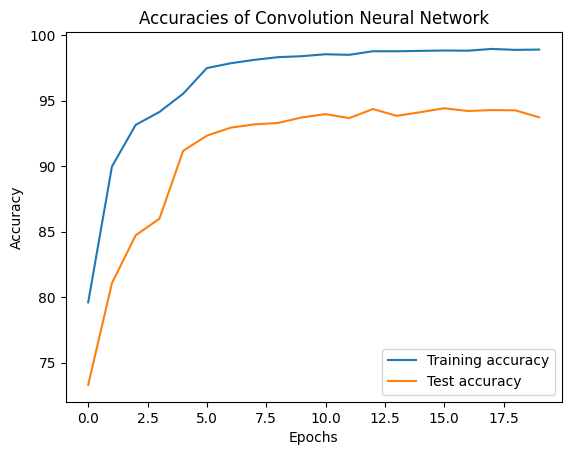

In [ ]:
plt.plot(train_accs_cnn, label='Training accuracy')
plt.plot(test_accs_cnn, label='Test accuracy')
plt.legend()
plt.title('Accuracies of Convolution Neural Network')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

## Table of results


In [ ]:
import pandas as pd

results = pd.DataFrame({
    "Model": ["Fully Connected", "Convolutional"],
    "Type of layer": ["4 linear", "2 convolutional, 2 linear"],
    "Optimizer": ["ADAM", "ADAM"],
    "Criterion": ["Cross Entropy", "Cross Entropy" ],
    "Learning rate": ["0.001", "0.001"],
    "Epochs": ["20", "20"],
    "Train Loss": [train_losses_fcnn[-1], train_losses_cnn[-1]],
    "Train Accuracy": [train_accs_fcnn[-1], train_accs_cnn[-1]],
    "Test Loss": [test_losses_fcnn[-1], test_losses_cnn[-1]],
    "Test Accuracy": [test_accs_fcnn[-1], test_accs_cnn[-1]]
})

In [ ]:
print(results)

             Model              Type of layer Optimizer      Criterion  \
0  Fully Connected                   4 linear      ADAM  Cross Entropy   
1    Convolutional  2 convolutional, 2 linear      ADAM  Cross Entropy   

  Learning rate Epochs  Train Loss  Train Accuracy  Test Loss  Test Accuracy  
0         0.001     20    1.522140       94.021812   1.645990      82.231571  
1         0.001     20    1.474161       98.822705   1.527011      94.130609  
